In [61]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [62]:
def get_original_pairwise_affinities(X: np.ndarray, perplexity: int = 10) -> np.ndarray:
    """
    Function to obtain affinities matrix.

    Parameters:
    X (np.ndarray): The input data array.
    perplexity (int): The perplexity value for the grid search.

    Returns:
    np.ndarray: The pairwise affinities matrix.
    """

    n = len(X)

    print("Computing Pairwise Affinities....")

    p_ij = np.zeros(shape=(n, n))
    for i in range(0, n):
        # Equation 1 numerator
        diff = X[i] - X
        σ_i = grid_search(diff, i, perplexity)  # Grid Search for σ_i
        norm = np.linalg.norm(diff, axis=1)
        p_ij[i, :] = np.exp(-(norm**2) / (2 * σ_i**2))

        # Set p = 0 when j = i
        np.fill_diagonal(p_ij, 0)

        # Equation 1
        p_ij[i, :] = p_ij[i, :] / np.sum(p_ij[i, :])

    # Set 0 values to minimum numpy value (ε approx. = 0)
    ε = np.nextafter(0, 1)
    p_ij = np.maximum(p_ij, ε)

    print("Completed Pairwise Affinities Matrix. \n")

    return p_ij

In [63]:
def grid_search(diff_i: np.ndarray, i: int, perplexity: int) -> float:
    """
    Helper function to obtain σ's based on user-specified perplexity.

    Parameters:
        diff_i (np.ndarray): Array containing the pairwise differences between data points.
        i (int): Index of the current data point.
        perplexity (int): User-specified perplexity value.

    Returns:
        float: The value of σ that satisfies the perplexity condition.
    """

    result = np.inf  # Set first result to be infinity

    norm = np.linalg.norm(diff_i, axis=1)
    std_norm = np.std(norm)  # Use standard deviation of norms to define search space

    for σ_search in np.linspace(0.01 * std_norm, 5 * std_norm, 200):
        # Equation 1 Numerator
        p = np.exp(-(norm**2) / (2 * σ_search**2))

        # Set p = 0 when i = j
        p[i] = 0

        # Equation 1 (ε -> 0)
        ε = np.nextafter(0, 1)
        p_new = np.maximum(p / np.sum(p), ε)

        # Shannon Entropy
        H = -np.sum(p_new * np.log2(p_new))

        # Get log(perplexity equation) as close to equality
        if np.abs(np.log(perplexity) - H * np.log(2)) < np.abs(result):
            result = np.log(perplexity) - H * np.log(2)
            σ = σ_search

    return σ

In [64]:
def get_symmetric_p_ij(p_ij: np.ndarray) -> np.ndarray:
    """
    Function to obtain symmetric affinities matrix utilized in t-SNE.

    Parameters:
    p_ij (np.ndarray): The input affinity matrix.

    Returns:
    np.ndarray: The symmetric affinities matrix.

    """
    print("Computing Symmetric p_ij matrix....")

    n = len(p_ij)
    p_ij_symmetric = np.zeros(shape=(n, n))
    for i in range(0, n):
        for j in range(0, n):
            p_ij_symmetric[i, j] = (p_ij[i, j] + p_ij[j, i]) / (2 * n)

    # Set 0 values to minimum numpy value (ε approx. = 0)
    ε = np.nextafter(0, 1)
    p_ij_symmetric = np.maximum(p_ij_symmetric, ε)

    print("Completed Symmetric p_ij Matrix. \n")

    return p_ij_symmetric

In [65]:
def initialization(
    X: np.ndarray, n_dimensions: int = 2, initialization: str = "random"
) -> np.ndarray:
    """
    Obtain initial solution for t-SNE either randomly or using PCA.

    Parameters:
        X (np.ndarray): The input data array.
        n_dimensions (int): The number of dimensions for the output solution. Default is 2.
        initialization (str): The initialization method. Can be 'random' or 'PCA'. Default is 'random'.

    Returns:
        np.ndarray: The initial solution for t-SNE.

    Raises:
        ValueError: If the initialization method is neither 'random' nor 'PCA'.
    """

    # Sample Initial Solution
    if initialization == "random" or initialization != "PCA":
        y0 = np.random.normal(loc=0, scale=1e-4, size=(len(X), n_dimensions))
    elif initialization == "PCA":
        X_centered = X - X.mean(axis=0)
        _, _, Vt = np.linalg.svd(X_centered)
        y0 = X_centered @ Vt.T[:, :n_dimensions]
    else:
        raise ValueError("Initialization must be 'random' or 'PCA'")

    return y0

In [66]:
def get_low_dimensional_affinities(Y: np.ndarray) -> np.ndarray:
    """
    Obtain low-dimensional affinities.

    Parameters:
    Y (np.ndarray): The low-dimensional representation of the data points.

    Returns:
    np.ndarray: The low-dimensional affinities matrix.
    """

    n = len(Y)
    q_ij = np.zeros(shape=(n, n))

    for i in range(0, n):
        # Equation 4 Numerator
        diff = Y[i] - Y
        norm = np.linalg.norm(diff, axis=1)
        q_ij[i, :] = (1 + norm**2) ** (-1)

    # Set p = 0 when j = i
    np.fill_diagonal(q_ij, 0)

    # Equation 4
    q_ij = q_ij / q_ij.sum()

    # Set 0 values to minimum numpy value (ε approx. = 0)
    ε = np.nextafter(0, 1)
    q_ij = np.maximum(q_ij, ε)

    return q_ij

In [67]:
def get_gradient(p_ij: np.ndarray, q_ij: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """
    Obtain gradient of cost function at current point Y.

    Parameters:
    p_ij (np.ndarray): The joint probability distribution matrix.
    q_ij (np.ndarray): The Student's t-distribution matrix.
    Y (np.ndarray): The current point in the low-dimensional space.

    Returns:
    np.ndarray: The gradient of the cost function at the current point Y.
    """

    n = len(p_ij)

    # Compute gradient
    gradient = np.zeros(shape=(n, Y.shape[1]))
    for i in range(0, n):
        # Equation 5
        diff = Y[i] - Y
        A = np.array([(p_ij[i, :] - q_ij[i, :])])
        B = np.array([(1 + np.linalg.norm(diff, axis=1)) ** (-1)])
        C = diff
        gradient[i] = 4 * np.sum((A * B).T * C, axis=0)

    return gradient

In [68]:
def tsne(
    X: np.ndarray,
    perplexity: int = 10,
    T: int = 1000,
    η: int = 200,
    early_exaggeration: int = 4,
    n_dimensions: int = 2,
):
    """
    t-SNE (t-Distributed Stochastic Neighbor Embedding) algorithm implementation.

    Args:
        X (np.ndarray): The input data matrix of shape (n_samples, n_features).
        perplexity (int, optional): The perplexity parameter. Default is 10.
        T (int, optional): The number of iterations for optimization. Default is 1000.
        η (int, optional): The learning rate for updating the low-dimensional embeddings. Default is 200.
        early_exaggeration (int, optional): The factor by which the pairwise affinities are exaggerated
            during the early iterations of optimization. Default is 4.
        n_dimensions (int, optional): The number of dimensions of the low-dimensional embeddings. Default is 2.

    Returns:
        list[np.ndarray, np.ndarray]: A list containing the final low-dimensional embeddings and the history
            of embeddings at each iteration.

    """
    n = len(X)

    # Get original affinities matrix
    p_ij = get_original_pairwise_affinities(X, perplexity)
    p_ij_symmetric = get_symmetric_p_ij(p_ij)

    # Initialization
    Y = np.zeros(shape=(T, n, n_dimensions))
    Y_minus1 = np.zeros(shape=(n, n_dimensions))
    Y[0] = Y_minus1
    Y1 = initialization(X, n_dimensions)
    Y[1] = np.array(Y1)

    print("Optimizing Low Dimensional Embedding....")
    # Optimization
    for t in range(1, T - 1):
        # Momentum & Early Exaggeration
        if t < 250:
            α = 0.5
            early_exaggeration = early_exaggeration
        else:
            α = 0.8
            early_exaggeration = 1

        # Get Low Dimensional Affinities
        q_ij = get_low_dimensional_affinities(Y[t])

        # Get Gradient of Cost Function
        gradient = get_gradient(early_exaggeration * p_ij_symmetric, q_ij, Y[t])

        # Update Rule
        Y[t + 1] = Y[t] - η * gradient + α * (Y[t] - Y[t - 1])  # Use negative gradient

        # Compute current value of cost function
        if t % 50 == 0 or t == 1:
            cost = np.sum(p_ij_symmetric * np.log(p_ij_symmetric / q_ij))
            print(f"Iteration {t}: Value of Cost Function is {cost}")

    print(
        f"Completed Low Dimensional Embedding: Final Value of Cost Function is {np.sum(p_ij_symmetric * np.log(p_ij_symmetric / q_ij))}"
    )
    solution = Y[-1]

    return solution, Y

In [69]:
# Fetch MNIST data
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X_total = pd.DataFrame(mnist["data"])
y_total = pd.DataFrame(mnist["target"])

X_reduced = X_total.sample(n=1000)
y_reduced = y_total.loc[X_reduced.index]

# PCA to keep 30 components
X = PCA(n_components=30).fit_transform(X_reduced) 

In [95]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,251.341518,-172.337170,646.036607,-604.508676,-731.343394,-394.328252,140.586490,-213.840221,-186.572194,304.120563,-348.215003,-235.468229,-129.481083,-328.668102,-118.429241,481.035929,-248.968566,-162.874649,287.666019,-197.109882,-73.503134,-60.051806,-111.112006,-204.358693,133.914488,84.065060,40.683162,-177.766592,180.384542,140.187306
1,-314.851523,-260.686369,43.224837,-274.154795,-11.658326,-400.286229,619.657685,-473.645934,653.590260,-123.466766,304.085900,-42.213692,-567.253035,-60.380442,25.391740,-96.726080,-269.402048,168.877171,-110.465960,-393.187552,-233.589601,-59.711270,-264.291254,78.537328,130.679766,50.508560,-77.018196,-579.371759,181.130936,314.739773
2,821.801836,-119.450767,-806.741011,970.782659,117.791691,-334.742575,243.026331,168.218781,238.916525,-114.226200,-348.352018,106.366866,-158.036067,-452.430266,-226.674346,-140.617751,-190.883022,130.276304,120.688707,22.305776,-14.538623,-30.525831,88.301608,-118.861242,205.166387,-178.592414,63.728619,250.294476,-28.771107,-0.764848
3,-510.040645,62.922287,307.400985,165.162939,624.308344,-231.669371,-305.342884,97.953858,127.782807,351.027661,-105.422489,-55.273943,25.601395,307.212445,-235.409108,-383.734024,-200.829018,-314.573820,88.500045,-29.167211,176.494905,150.133315,254.472971,-61.808599,21.370583,-9.350394,122.120168,251.869746,-5.410200,-37.513658
4,-14.882274,-1092.338219,-128.897715,-91.210132,-359.246382,276.104464,-110.414882,303.123749,-120.011279,241.486436,22.119603,-282.978749,-16.653113,-7.923163,-266.088926,-8.746223,-128.173488,76.106163,234.572878,111.957131,-418.916130,6.110948,448.029870,212.960988,130.582723,-8.129629,159.781271,40.345729,-127.285915,-284.272562


In [96]:
X = np.array(X)

p_ij = get_original_pairwise_affinities(X)

Computing Pairwise Affinities....
Completed Pairwise Affinities Matrix. 



In [97]:
pd.DataFrame(p_ij).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,4.940656e-324,1.821657e-07,1.037453e-12,1.014894e-09,1.117579e-07,3.180475e-08,5.791328e-12,6.567848e-08,1.

In [98]:
p_ij_symmetric = get_symmetric_p_ij(p_ij)

Computing Symmetric p_ij matrix....
Completed Symmetric p_ij Matrix. 



In [99]:
pd.DataFrame(p_ij_symmetric).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,4.940656e-324,2.928757e-08,1.262973e-11,5.384684e-13,1.907009e-10,1.858131e-11,1.554646e-11,2.973141e-09,6.

In [100]:
y0 = initialization(X, 2, "random")
pd.DataFrame(y0).head()

,0,1
0,-0.000025,-0.000051
1,0.000034,0.000169
2,-0.000146,-0.000128
3,0.000018,-0.000113
4,-0.000106,-0.000102


In [101]:
q_ij = get_low_dimensional_affinities(y0)
pd.DataFrame(q_ij).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,4.940656e-324,1.001001e-06,1.001001e-06,1.001001e-06,1.001001e-06,0.000001,0.000001,0.000001,0.000001,0.000

In [102]:
gradient = get_gradient(p_ij_symmetric, q_ij, y0)
pd.DataFrame(gradient).head()

,0,1
0,3.440979e-08,7.813820e-09
1,-2.469521e-07,-5.151329e-07
2,3.244037e-07,9.484072e-08
3,4.419449e-07,-4.531208e-07
4,7.304593e-08,2.699164e-07


In [104]:
solution, Y = tsne(
    X, perplexity=10, T=1000, η=200, early_exaggeration=4, n_dimensions=2
)

Computing Pairwise Affinities....
Completed Pairwise Affinities Matrix. 

Computing Symmetric p_ij matrix....
Completed Symmetric p_ij Matrix. 

Optimizing Low Dimensional Embedding....
Iteration 1: Value of Cost Function is 4.445604299609592
Iteration 50: Value of Cost Function is 2.7049394197024554
Iteration 100: Value of Cost Function is 2.411386294688672
Iteration 150: Value of Cost Function is 2.370099941722107
Iteration 200: Value of Cost Function is 2.362135171508304
Iteration 250: Value of Cost Function is 2.35928319350489
Iteration 300: Value of Cost Function is 1.2494410859712
Iteration 350: Value of Cost Function is 1.157905121298321
Iteration 400: Value of Cost Function is 1.12892053939353
Iteration 450: Value of Cost Function is 1.1142709861063884
Iteration 500: Value of Cost Function is 1.1046409694887442
Iteration 550: Value of Cost Function is 1.0978103425607435
Iteration 600: Value of Cost Function is 1.0932635436151767
Iteration 650: Value of Cost Function is 1.089793

In [105]:
pd.DataFrame(solution)

,0,1
0,-150.759538,-177.678641
1,74.161478,34.137389
2,98.119584,-164.411579
3,-54.590937,-35.019846
4,-184.648020,85.079192
...,...,...
995,165.020130,128.444057
996,191.895674,-122.030675
997,-190.773637,121.281332
998,-123.115617,2.636375


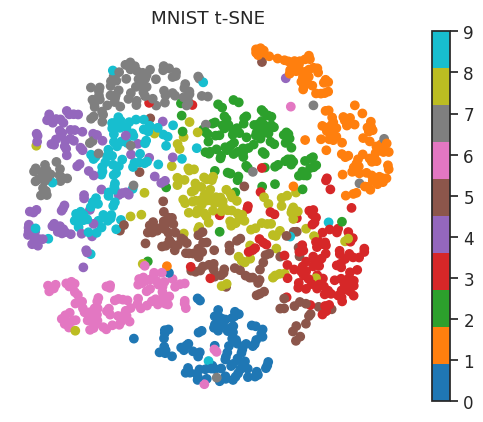

In [108]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
g1 = ax.scatter(solution[:, 0], solution[:, 1], c=y_reduced, cmap="tab10")
ax.axis("off")
ax.set_title("MNIST t-SNE")
plt.colorbar(g1, ax=ax)
plt.show()